# RNN BUILD

* Først hente og rense data ved bruk av eget lib
* Så sette opp en modell
* Trene og validere -> Deretter teste på ny data
* Lagre modellen

Ops ops: Modellen kan kun bukes på data med 3 dimensjoner. Det betyr at det alltid på komme i en sekvens. min (2, 30, 5)

In [110]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lib.rens import rens
from lib.create_dataset import create_dataset
from lib.make_ready import make_ready


In [129]:
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def add_data(word):
    ordet = 'data/' + word
    return ordet

In [121]:
filer = list(map(add_data, os.listdir('data/')))[0:5] # test 54:60 mellom 10 og 14 er noe feil
data = make_ready().use_stockstats(filer)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [122]:
def prepare_data_for_training(data):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.extend(datax)
        datayes.extend(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)


def prepare_data_for_test(data):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.append(datax)
        datayes.append(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)
    
    
dataxes, datayes = prepare_data_for_training(data)


In [123]:
# split in train and val for training
X_train, X_test, y_train, y_test = train_test_split(dataxes, datayes, test_size=0.33, shuffle=True, random_state=42)
X_train.shape

(1041, 30, 5)

## Lage modellen
Bruker LSTM. gode greier. Har ikke gridsearched eller kfold.

In [133]:
model = Sequential()

model.add(LSTM(units=64, input_dim=5, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(10))

model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, None, 64)          17920     
_________________________________________________________________
dropout_26 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                650       
Total params: 51,594
Trainable params: 51,594
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

Train on 1041 samples, validate on 514 samples
Epoch 1/50
1041/1041 [==============================] - 13s 12ms/sample - loss: 0.2373 - mae: 0.3598 - r2_score: 0.2516 - val_loss: 0.1774 - val_mae: 0.3136 - val_r2_score: 0.5027
Epoch 2/50
1041/1041 [==============================] - 2s 2ms/sample - loss: 0.1651 - mae: 0.3059 - r2_score: 0.4435 - val_loss: 0.1636 - val_mae: 0.3027 - val_r2_score: 0.5560
Epoch 3/50
1041/1041 [==============================] - 2s 2ms/sample - loss: 0.1526 - mae: 0.2950 - r2_score: 0.4851 - val_loss: 0.1521 - val_mae: 0.2952 - val_r2_score: 0.5777
Epoch 4/50
1041/1041 [==============================] - 2s 2ms/sample - loss: 0.1425 - mae: 0.2832 - r2_score: 0.5545 - val_loss: 0.1436 - val_mae: 0.2813 - val_r2_score: 0.6100
Epoch 5/50
  64/1041 [>.............................] - ETA: 1s - loss: 0.1237 - mae: 0.2732 - r2_score: 0.6503

### Plotte validation kurve

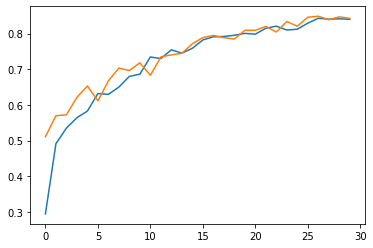

In [132]:
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
#plt.xlim(50,100)
#plt.ylim(0.0, 0.025)

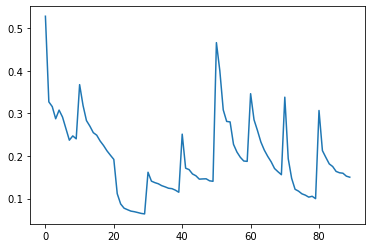

In [265]:
#plt.plot(history.history['loss'])
flatten = [j for sub in all_history for j in sub]
#all_history
#for h in all_history:
plt.plot(flatten)

### Gjennomføre en tes 
Henter helt nye data for å gjennomføre en test på modellen.

In [95]:
filer = list(map(add_data, os.listdir('data/')))[50:52] # test 54:60
data_test = make_ready(filer)
dataxes, datayes = prepare_data_for_test(data)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
C:\Users\Stian\anaconda3\lib\site-packages\ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [96]:
pred = []

for x in dataxes:
    pred.append(model.predict(x))

pred = np.array(pred)

C:\Users\Stian\anaconda3\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [97]:
pred.shape

(4,)

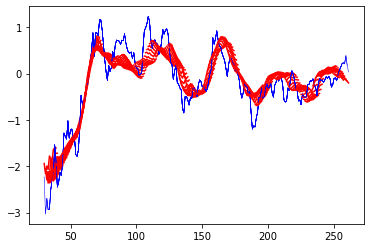

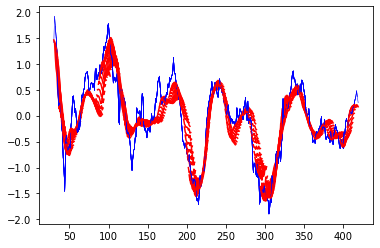

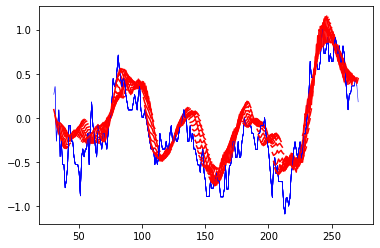

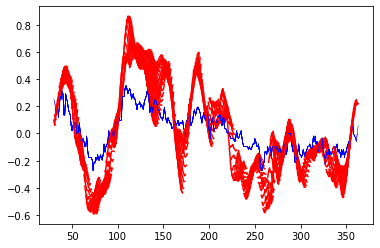

In [100]:
for i, p in enumerate(pred):
    for j, y in enumerate(p):
        
    #print(p.shape)
        plt.plot(range(30+j,40+j), datayes[i][j], c='blue', linewidth=.5)
        plt.plot(range(30+j,40+j), y, c='red')
    plt.show()

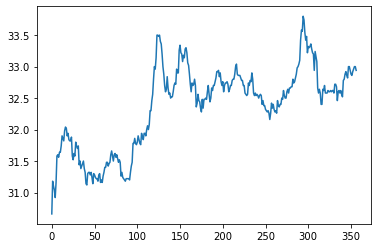

In [39]:
plt.plot(data[0]['open'])

## Save model

In [152]:
# Save model

model.save('models/rnn_model.h5')

In [56]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 0223-158D

 Directory of C:\Users\Stian\Documents\School\99. Div\intradag

19.09.2020  00.30    <DIR>          .
19.09.2020  00.30    <DIR>          ..
16.08.2020  17.38    <DIR>          .idea
01.09.2020  19.48    <DIR>          .ipynb_checkpoints
24.08.2020  21.27    <DIR>          data
26.08.2020  22.16    <DIR>          history
18.09.2020  19.30    <DIR>          images
25.08.2020  13.08    <DIR>          lib
30.08.2020  10.25           514ÿ958 make_model.ipynb
19.09.2020  00.30    <DIR>          models
29.08.2020  11.29               664 README.md
19.09.2020  00.29           132ÿ506 RNN_trial.ipynb
16.08.2020  17.14         3ÿ922ÿ732 smadaytrade.ipynb
01.09.2020  20.07           775ÿ971 use_model.ipynb
17.08.2020  12.53    <DIR>          __pycache__
               5 File(s)      5ÿ346ÿ831 bytes
              10 Dir(s)  75ÿ003ÿ355ÿ136 bytes free
